# Train and serve a TensorFlow model with TensorFlow Serving

This Notebook showcases how Deep Learning can benefit from hybrid Cloud-HPC scenarios, in particular to offload the computationally demanding training phase to an HPC facility, and offering the resulting network as-a-Service on a Cloud achitecture to answer time-constrained inference queries.

The notebook is a modified version of [this one](https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb), which focuses mainly on Google Colab. Since we are not interested in pure performance for this use case, we use the small [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset and a very small custom Convolutional Neural Network (CNN).

The training phase has been offloaded to an HPC node on the [HPC4AI facility](https://hpc4ai.unito.it/), equiped with four NVIDIA Tesla V100 and two Intel Xeon Gols 6230 sockets. Then, the trained model is sent to a pre-existing TensorFlow Serving Pod on a Kubernetes cluster, hosted on the OpenStack-based  HPC4AI cloud.

Let's start with an import of all the required modules

In [1]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.4.1


Then we import the Fashion MNIST dataset, containing 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4423680/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


At this point, we create our neural network model. Since we are not focused on performances, let's use the simplest possible CNN.

In [3]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


Now we train the model for one epoch. Since this is commonly a computationally demanding step, we offload it to an HPC node through an SSH connector. For portability purposes, we execute the command on a Docker container on the remote environment, created from a standard `jupyter/tensorflow-notebook` image.

In order to replicate the experiment, you need to set the correct credentials in the Notebook metadata (e.g., `username` and `sshKey`) and, if necessary, modify the script template at `environment/hpc/ssh_template.jinja2`.

Please note that the TensorFlow network was not trivially serialisable by the `dill` engine, so we were forced to implement custom `predump` and `postload` directives to correctly handle the data transfer.

In [4]:
testing = False
epochs = 20

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = tf.keras.models.clone_model(model)
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=epochs)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
print('\nTest accuracy: {}'.format(test_acc))

INFO:tensorflow:Assets written to: /tmp/tmpxicla_tz/assets
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost

At this point, the `model` variable contains the trained model's weights. To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.

The path of the saved model is stored in the `export_path` variable to be easily referred to in the following cells.

In [5]:
import tempfile

export_path = tempfile.mkdtemp()
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/tmpeji93ti1

INFO:tensorflow:Assets written to: /tmp/tmpeji93ti1/assets

Saved model:
total 72
drwxr-xr-x 2 jovyan users  4096 Apr 15 23:44 assets
-rw-r--r-- 1 jovyan users 63956 Apr 15 23:44 saved_model.pb
drwxr-xr-x 2 jovyan users  4096 Apr 15 23:44 variables


At this point, we can send our model to a [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) instance for inference. We deploy a Kubernetes Pod containing a `tensorflow-serving` container, send the model folder as an input dependency and copy it on the `/models/model` path in the remote file-system, in order to start serving it.

In [8]:
%%bash -s {export_path}
rm -rf "/models/model"
mkdir "/models/model"
cp -r "$1" "/models/model/1"

Now we can test if the inference server to test is actually able to correctly classify objects. Since the service is not publicly exposed, we use *Jupyter-workflow* to connect to the remote service and perform a local HTTP request to obtain the prediction.

In [9]:
import json
import requests

data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


Now we can show the prediction result locally on the Notebook, using `matplotlib`

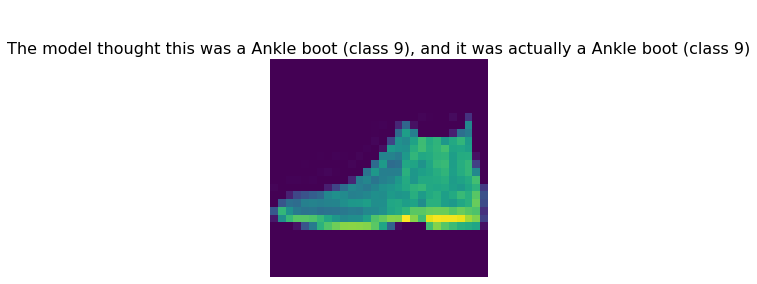

In [11]:
def show(idx, title):
    plt.figure()
    plt.imshow(test_images[idx].reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))